# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_3Av2:oracle.run1.framed -> cores+wisig",
    "device": "cuda",
    "lr": 0.0001,
    "x_shape": [2, 200],
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 200]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 16000, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10.",
                "1-11.",
                "1-15.",
                "1-16.",
                "1-17.",
                "1-18.",
                "1-19.",
                "10-4.",
                "10-7.",
                "11-1.",
                "11-14.",
                "11-17.",
                "11-20.",
                "11-7.",
                "13-20.",
                "13-8.",
                "14-10.",
                "14-11.",
                "14-14.",
                "14-7.",
                "15-1.",
                "15-20.",
                "16-1.",
                "16-16.",
                "17-10.",
                "17-11.",
                "17-2.",
                "19-1.",
                "19-16.",
                "19-19.",
                "19-20.",
                "19-3.",
                "2-10.",
                "2-11.",
                "2-17.",
                "2-18.",
                "2-20.",
                "2-3.",
                "2-4.",
                "2-5.",
                "2-6.",
                "2-7.",
                "2-8.",
                "3-13.",
                "3-18.",
                "3-3.",
                "4-1.",
                "4-10.",
                "4-11.",
                "4-19.",
                "5-5.",
                "6-15.",
                "7-10.",
                "7-14.",
                "8-18.",
                "8-20.",
                "8-3.",
                "8-8.",
            ],
            "domains": [1, 2, 3, 4, 5],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/cores.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power", "take_200"],
            "episode_transforms": [],
            "domain_prefix": "C_",
        },
        {
            "labels": [
                "1-10",
                "1-12",
                "1-14",
                "1-16",
                "1-18",
                "1-19",
                "1-8",
                "10-11",
                "10-17",
                "10-4",
                "10-7",
                "11-1",
                "11-10",
                "11-19",
                "11-20",
                "11-4",
                "11-7",
                "12-19",
                "12-20",
                "12-7",
                "13-14",
                "13-18",
                "13-19",
                "13-20",
                "13-3",
                "13-7",
                "14-10",
                "14-11",
                "14-12",
                "14-13",
                "14-14",
                "14-19",
                "14-20",
                "14-7",
                "14-8",
                "14-9",
                "15-1",
                "15-19",
                "15-6",
                "16-1",
                "16-16",
                "16-19",
                "16-20",
                "17-10",
                "17-11",
                "18-1",
                "18-10",
                "18-11",
                "18-12",
                "18-13",
                "18-14",
                "18-15",
                "18-16",
                "18-17",
                "18-19",
                "18-2",
                "18-20",
                "18-4",
                "18-5",
                "18-7",
                "18-8",
                "18-9",
                "19-1",
                "19-10",
                "19-11",
                "19-12",
                "19-13",
                "19-14",
                "19-15",
                "19-19",
                "19-2",
                "19-20",
                "19-3",
                "19-4",
                "19-6",
                "19-7",
                "19-8",
                "19-9",
                "2-1",
                "2-13",
                "2-15",
                "2-3",
                "2-4",
                "2-5",
                "2-6",
                "2-7",
                "2-8",
                "20-1",
                "20-12",
                "20-14",
                "20-15",
                "20-16",
                "20-18",
                "20-19",
                "20-20",
                "20-3",
                "20-4",
                "20-5",
                "20-7",
                "20-8",
                "3-1",
                "3-13",
                "3-18",
                "3-2",
                "3-8",
                "4-1",
                "4-10",
                "4-11",
                "5-1",
                "5-5",
                "6-1",
                "6-15",
                "6-6",
                "7-10",
                "7-11",
                "7-12",
                "7-13",
                "7-14",
                "7-7",
                "7-8",
                "7-9",
                "8-1",
                "8-13",
                "8-14",
                "8-18",
                "8-20",
                "8-3",
                "8-8",
                "9-1",
                "9-7",
            ],
            "domains": [1, 2, 3, 4],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/wisig.node3-19.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power", "take_200"],
            "episode_transforms": [],
            "domain_prefix": "W_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power", "take_200", "resample_20Msps_to_25Msps"],
            "episode_transforms": [],
            "domain_prefix": "O_",
        },
    ],
    "seed": 420,
    "dataset_seed": 420,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'O_50', 'O_32', 'O_38', 'O_26', 'O_14', 'O_44', 'O_8', 'O_20'}


{'W_4', 'W_2', 'C_1', 'C_5', 'C_2', 'C_3', 'C_4', 'W_1', 'W_3'}


tensor([[[ 0.6470,  0.5780, -0.6104,  ...,  0.1196, -1.0641,  0.0498],
         [ 0.1549,  1.2563,  0.3941,  ...,  0.8166,  0.6102,  0.8082]],

        [[-0.6667,  0.2748,  0.8156,  ...,  0.4889,  1.1788,  0.6502],
         [-0.5000, -1.2580,  0.2088,  ..., -0.5176,  0.3522, -0.6378]],

        [[-0.0371,  1.1261,  0.4751,  ...,  0.7801,  0.4409,  0.7636],
         [-0.5844, -0.4009,  0.6742,  ...,  0.0045,  1.1223,  0.0137]],

        ...,

        [[ 0.7062,  0.4473, -0.7024,  ..., -0.0110, -1.2104, -0.1140],
         [ 0.1657,  1.1509,  0.2787,  ...,  0.8103,  0.5784,  0.9839]],

        [[ 0.9780,  0.7687, -1.0005,  ..., -0.1678, -0.3604,  1.0122],
         [ 0.0998,  0.8762,  0.2805,  ...,  0.9712,  0.7959,  0.6791]],

        [[ 0.8678,  0.9529, -0.6981,  ...,  0.5441,  0.5057,  1.1785],
         [-0.6983,  0.1518,  1.1143,  ...,  1.0081,  0.5522, -0.4006]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 200)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 49.0186, train_label_loss: 3.0158, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 3665.8121, train_label_loss: 1.1221, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 3732.2502, train_label_loss: 1.0572, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 3732.1741, train_label_loss: 1.0512, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 3686.8414, train_label_loss: 0.8011, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 3708.1998, train_label_loss: 1.0275, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 3701.4860, train_label_loss: 0.9010, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 3701.1762, train_label_loss: 0.8206, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 3706.8024, train_label_loss: 1.4223, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 3701.2003, train_label_loss: 0.6345, 


epoch: 1, source_val_acc_label: 0.6882, target_val_acc_label: 0.4350, source_val_label_loss: 6.7596, target_val_label_loss: 1725.9602, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 4.3840, train_label_loss: 1.1532, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 3676.8934, train_label_loss: 1.0564, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 3706.4448, train_label_loss: 0.7986, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 3710.4876, train_label_loss: 0.7179, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 3705.6105, train_label_loss: 0.8316, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 3709.8936, train_label_loss: 0.6971, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 3717.4975, train_label_loss: 0.4916, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 3698.1251, train_label_loss: 0.8296, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 3713.6078, train_label_loss: 1.1295, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 3698.7090, train_label_loss: 0.4352, 


epoch: 2, source_val_acc_label: 0.7475, target_val_acc_label: 0.5574, source_val_label_loss: 0.7139, target_val_label_loss: 293.3095, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 4.3587, train_label_loss: 0.4684, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 3628.2923, train_label_loss: 0.7754, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 3673.1586, train_label_loss: 1.0341, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 3677.5952, train_label_loss: 0.4971, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 3651.4995, train_label_loss: 0.6791, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 3671.3541, train_label_loss: 0.7230, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 3681.1544, train_label_loss: 0.3593, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 3682.9163, train_label_loss: 0.5078, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 3697.3223, train_label_loss: 0.5166, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 3692.9306, train_label_loss: 0.4072, 


epoch: 3, source_val_acc_label: 0.7936, target_val_acc_label: 0.5831, source_val_label_loss: 0.5752, target_val_label_loss: 307.6596, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 4.3564, train_label_loss: 0.5806, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 3649.6157, train_label_loss: 0.6314, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 3688.9204, train_label_loss: 0.2561, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 3691.4804, train_label_loss: 0.3708, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 3683.4547, train_label_loss: 0.7636, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 3678.1636, train_label_loss: 0.9244, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 3659.1082, train_label_loss: 0.4721, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 3643.6728, train_label_loss: 0.4713, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 3617.5966, train_label_loss: 0.5278, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 3634.3598, train_label_loss: 0.4464, 


epoch: 4, source_val_acc_label: 0.7937, target_val_acc_label: 0.5884, source_val_label_loss: 0.5623, target_val_label_loss: 315.2371, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 4.3564, train_label_loss: 0.3705, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 3662.8564, train_label_loss: 0.9168, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 3693.2687, train_label_loss: 0.4706, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 3685.4219, train_label_loss: 0.3389, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 3672.8620, train_label_loss: 0.9733, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 3670.0883, train_label_loss: 0.3249, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 3711.4003, train_label_loss: 0.4205, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 3703.5477, train_label_loss: 0.4511, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 3705.8492, train_label_loss: 0.4714, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 3688.8390, train_label_loss: 0.2638, 


epoch: 5, source_val_acc_label: 0.8276, target_val_acc_label: 0.6092, source_val_label_loss: 0.4916, target_val_label_loss: 349.7066, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 4.4200, train_label_loss: 0.1268, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 3650.3502, train_label_loss: 0.3361, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 3671.4707, train_label_loss: 0.7728, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 3698.6764, train_label_loss: 0.7563, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 3703.9176, train_label_loss: 0.2513, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 3713.7304, train_label_loss: 0.1809, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 3708.5924, train_label_loss: 0.6150, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 3709.1493, train_label_loss: 0.6906, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 3713.9142, train_label_loss: 0.9570, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 3704.8942, train_label_loss: 0.6936, 


epoch: 6, source_val_acc_label: 0.8330, target_val_acc_label: 0.6109, source_val_label_loss: 0.4642, target_val_label_loss: 338.9778, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 4.3595, train_label_loss: 0.3533, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 3677.2142, train_label_loss: 0.7756, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 3718.7473, train_label_loss: 0.1875, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 3695.7364, train_label_loss: 0.3622, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 3670.2742, train_label_loss: 0.2623, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 3690.9063, train_label_loss: 0.2757, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 3723.7896, train_label_loss: 0.2666, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 3695.6180, train_label_loss: 0.8225, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 3712.8673, train_label_loss: 0.4294, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 3718.9926, train_label_loss: 0.5094, 


epoch: 7, source_val_acc_label: 0.8304, target_val_acc_label: 0.6119, source_val_label_loss: 0.4706, target_val_label_loss: 366.5678, 


New best


epoch: 8, [batch: 1 / 6720], examples_per_second: 4.3764, train_label_loss: 0.2705, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 3676.5725, train_label_loss: 0.3063, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 3706.9192, train_label_loss: 0.1993, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 3713.2047, train_label_loss: 0.3497, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 3684.5127, train_label_loss: 0.2001, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 3686.5764, train_label_loss: 0.3331, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 3681.5588, train_label_loss: 0.1638, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 3641.8969, train_label_loss: 0.4642, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 3699.0000, train_label_loss: 0.1300, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 3747.0375, train_label_loss: 0.2912, 


epoch: 8, source_val_acc_label: 0.8573, target_val_acc_label: 0.6097, source_val_label_loss: 0.4061, target_val_label_loss: 407.7446, 


epoch: 9, [batch: 1 / 6720], examples_per_second: 4.3478, train_label_loss: 0.6995, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 3659.3524, train_label_loss: 0.5600, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 3716.1773, train_label_loss: 0.3913, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 3715.7119, train_label_loss: 0.5492, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 3693.0758, train_label_loss: 0.2539, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 3714.7058, train_label_loss: 0.6807, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 3714.5601, train_label_loss: 0.3886, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 3700.5668, train_label_loss: 0.2813, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 3710.9623, train_label_loss: 0.0619, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 3703.8212, train_label_loss: 0.4726, 


epoch: 9, source_val_acc_label: 0.8763, target_val_acc_label: 0.6173, source_val_label_loss: 0.3395, target_val_label_loss: 461.8210, 


New best


epoch: 10, [batch: 1 / 6720], examples_per_second: 4.3266, train_label_loss: 0.0617, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 3664.4801, train_label_loss: 0.3705, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 3730.1170, train_label_loss: 0.2901, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 3716.0881, train_label_loss: 0.2990, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 3693.8815, train_label_loss: 0.0953, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 3712.1738, train_label_loss: 0.5246, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 3721.7033, train_label_loss: 0.0857, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 3703.4516, train_label_loss: 0.4579, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 3706.5761, train_label_loss: 0.1403, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 3693.1271, train_label_loss: 0.1139, 


epoch: 10, source_val_acc_label: 0.8727, target_val_acc_label: 0.6180, source_val_label_loss: 0.3534, target_val_label_loss: 466.4078, 


New best


epoch: 11, [batch: 1 / 6720], examples_per_second: 4.3251, train_label_loss: 0.2249, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 3658.2585, train_label_loss: 0.2798, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 3712.7066, train_label_loss: 0.4297, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 3683.8779, train_label_loss: 0.4550, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 3670.6194, train_label_loss: 0.0756, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 3700.5055, train_label_loss: 0.8266, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 3711.8024, train_label_loss: 0.3106, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 3707.7434, train_label_loss: 0.6247, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 3710.1186, train_label_loss: 0.0785, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 3702.2092, train_label_loss: 0.0725, 


epoch: 11, source_val_acc_label: 0.8759, target_val_acc_label: 0.6154, source_val_label_loss: 0.3380, target_val_label_loss: 516.7914, 


epoch: 12, [batch: 1 / 6720], examples_per_second: 4.3733, train_label_loss: 0.2892, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 3675.0980, train_label_loss: 0.5903, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 3708.8877, train_label_loss: 0.0308, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 3705.5386, train_label_loss: 0.3652, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 3677.8548, train_label_loss: 0.1821, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 3706.1441, train_label_loss: 0.4800, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 3712.8352, train_label_loss: 0.8275, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 3701.6692, train_label_loss: 0.0628, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 3709.2375, train_label_loss: 0.1081, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 3718.0442, train_label_loss: 0.4603, 


epoch: 12, source_val_acc_label: 0.8783, target_val_acc_label: 0.6185, source_val_label_loss: 0.3401, target_val_label_loss: 530.1132, 


New best


epoch: 13, [batch: 1 / 6720], examples_per_second: 4.3428, train_label_loss: 0.1366, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 3692.6333, train_label_loss: 0.3034, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 3716.4449, train_label_loss: 0.1089, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 3697.4701, train_label_loss: 0.2628, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 3686.8011, train_label_loss: 0.2866, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 3716.6611, train_label_loss: 0.3692, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 3708.6857, train_label_loss: 0.2355, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 3707.1851, train_label_loss: 0.0501, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 3698.9706, train_label_loss: 0.3306, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 3715.5617, train_label_loss: 0.2153, 


epoch: 13, source_val_acc_label: 0.8904, target_val_acc_label: 0.6220, source_val_label_loss: 0.3126, target_val_label_loss: 588.2139, 


New best


epoch: 14, [batch: 1 / 6720], examples_per_second: 4.3308, train_label_loss: 0.4022, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3653.6337, train_label_loss: 0.0454, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 3716.1349, train_label_loss: 0.5943, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3724.3113, train_label_loss: 0.2085, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3696.4630, train_label_loss: 0.0676, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 3715.5083, train_label_loss: 0.5326, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3721.8823, train_label_loss: 0.1801, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3667.9487, train_label_loss: 0.1082, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 3637.8006, train_label_loss: 0.1345, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 3655.6831, train_label_loss: 0.4841, 


epoch: 14, source_val_acc_label: 0.8875, target_val_acc_label: 0.6028, source_val_label_loss: 0.3125, target_val_label_loss: 610.2534, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 4.3417, train_label_loss: 0.1812, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 3642.0490, train_label_loss: 0.1125, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 3664.7686, train_label_loss: 0.1313, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 3691.4595, train_label_loss: 0.2110, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 3676.6373, train_label_loss: 0.3645, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 3689.3325, train_label_loss: 0.1233, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 3681.9367, train_label_loss: 0.3403, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 3648.2394, train_label_loss: 0.2856, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 3681.2022, train_label_loss: 0.0780, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 3676.9617, train_label_loss: 0.0671, 


epoch: 15, source_val_acc_label: 0.8876, target_val_acc_label: 0.6021, source_val_label_loss: 0.3251, target_val_label_loss: 648.4722, 


epoch: 16, [batch: 1 / 6720], examples_per_second: 4.3784, train_label_loss: 0.1378, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 3634.4539, train_label_loss: 0.1612, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 3684.3173, train_label_loss: 0.1524, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 3682.2541, train_label_loss: 0.4880, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 3677.3517, train_label_loss: 0.0724, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 3678.7311, train_label_loss: 0.3018, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 3600.3003, train_label_loss: 0.1539, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 3694.6390, train_label_loss: 0.2206, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 3708.9418, train_label_loss: 0.2790, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 3719.3932, train_label_loss: 0.3075, 


epoch: 16, source_val_acc_label: 0.8838, target_val_acc_label: 0.5981, source_val_label_loss: 0.3320, target_val_label_loss: 712.9875, 


epoch: 17, [batch: 1 / 6720], examples_per_second: 4.3453, train_label_loss: 0.2106, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 3675.2457, train_label_loss: 0.2365, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 3720.2183, train_label_loss: 0.2596, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 3714.2402, train_label_loss: 0.3943, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 3692.7436, train_label_loss: 0.0553, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 3717.3223, train_label_loss: 0.0792, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 3717.4573, train_label_loss: 0.5368, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 3710.9901, train_label_loss: 0.0246, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 3693.6391, train_label_loss: 0.2442, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 3716.3831, train_label_loss: 0.1905, 


epoch: 17, source_val_acc_label: 0.8853, target_val_acc_label: 0.5962, source_val_label_loss: 0.3257, target_val_label_loss: 790.8940, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

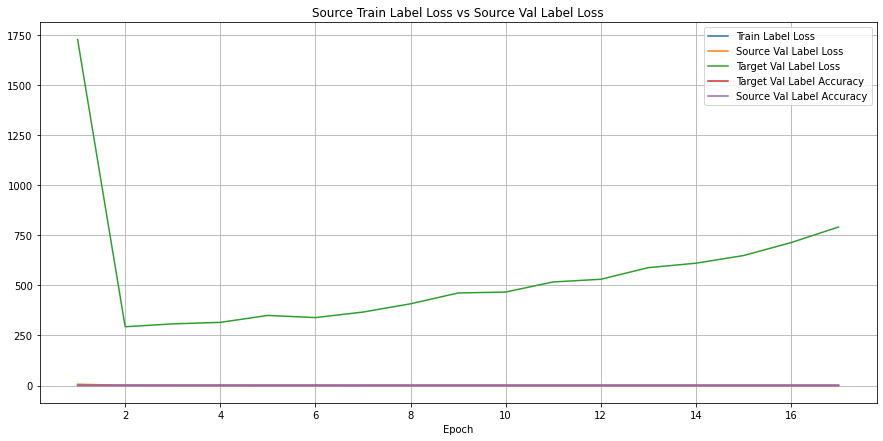

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

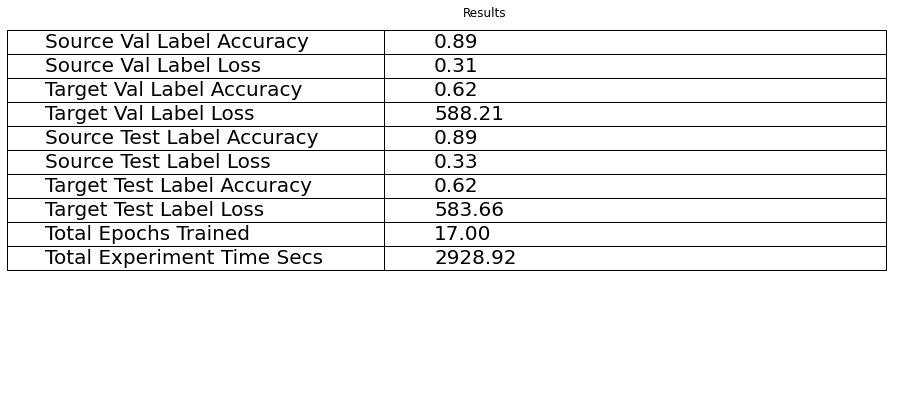

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

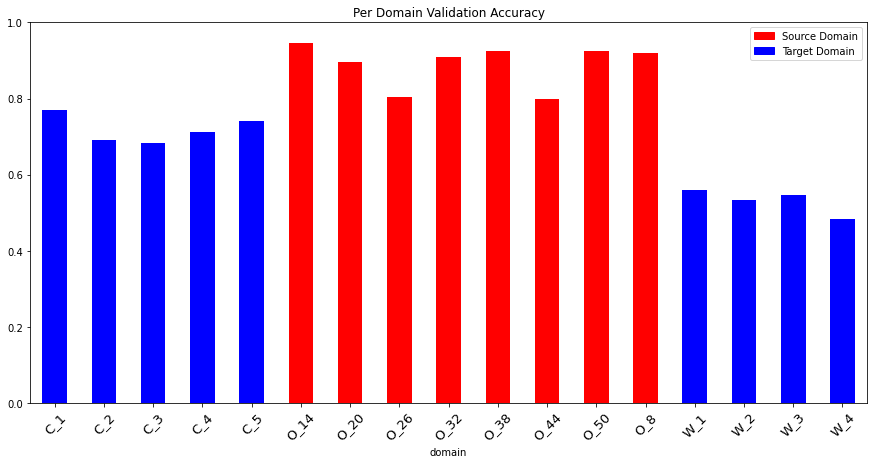

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.8895833333333333 Target Test Label Accuracy: 0.6223170896328294
Source Val Label Accuracy: 0.8904296875 Target Val Label Accuracy: 0.6219796814936848


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_3Av2:oracle.run1.framed -> cores+wisig", "parameters": {"experiment_name": "tl_3Av2:oracle.run1.framed -> cores+wisig", "device": "cuda", "lr": 0.0001, "x_shape": [2, 200], "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 200]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_